# Uber & Lyft Price Prediction in Boston    🚗

---

*By: Yra Climaco*

*Date: September 5, 2025*

## Introduction 📖
---
This project aims to build a machine learning model to predict the price of an Uber or Lyft ride. The analysis is based on a dataset from [Kaggle](https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma/data) that includes ride details, weather conditions, and timestamps for trips around Boston.

The primary steps in this notebook are:
1.  **Data Cleaning & Feature Engineering**: Prepare the data and create new, informative features.
2.  **Exploratory Data Analysis (EDA)**: Visualize the data to uncover key patterns and relationships.
3.  **Data Preprocessing**: Prepare the data for modeling by encoding and scaling features.
4.  **Modeling & Evaluation**: Train a Linear Regression model and evaluate its performance, as well as conduct a feature importance analysis.

## Executive Summary 🚖
---

This project analyzes Uber and Lyft ride data to uncover patterns in pricing and build a predictive regression model. Through exploratory data analysis, I identify key factors that influence fares, such as distance, surge multipliers, time of day, and weather conditions. The regression model performs strongly, achieving a 93% R-squared score and an average error of about $1.78 per ride, while highlighting distance and service type as the dominant predictors of price. These findings not only demonstrate core data science skills (EDA, feature engineering, and modeling) but also provide practical insights into ride-hailing pricing dynamics.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 1. Data Cleaning & Feature Engineering 🧹
---
Before analysis, the data must be cleaned and organized. I started by dropping rows with missing `price` values as this is our target variable. 

The raw `timestamp` is not useful for the model, so I converted it into a `datetime` object and engineered the following features to capture time-based trends:
* **day_name**: Extracts the full name of the day (e.g., 'Monday', 'Tuesday'). This is primarily useful for the EDA to have easy-to-read visualizations.
* **day_of_week**: To see if prices differ between weekdays and weekends.

In [8]:
df = pd.read_csv('rideshare_kaggle.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

**Initial Findings:** The dataset contains over 693,000 rows and 57 columns. The `price` column, our target variable, has missing values that need to be handled. The `datetime` column is stored as an `object` (string) and needs to be converted to a proper datetime format for feature engineering.

In [9]:
# Drop null price values
df.dropna(subset = ['price'], inplace = True)

# Convert the 'datetime' column to a proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Engineer new time-based features for better analysis
df['day_name'] = df['datetime'].dt.day_name()
df['day_of_week'] = df['datetime'].dt.dayofweek

# 2. Exploratory Data Analysis 📊
---
In this section, I'll create visualizations to understand the relationships between different features and the ride price.

### How does price change during hours of the day?
I'll plot the average price for each hour (0-23) to identify daily patterns, such as rush hour peaks.

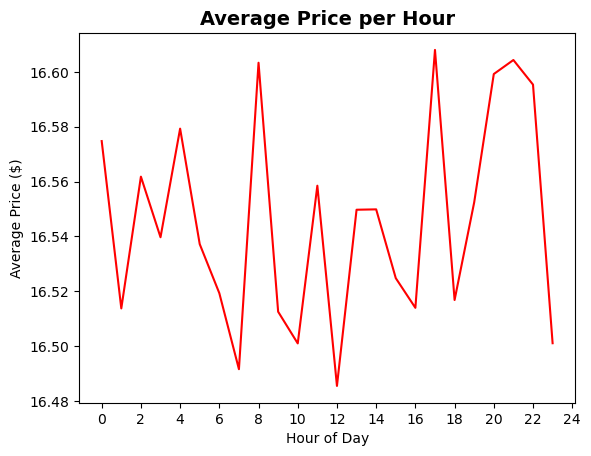

In [10]:
hourly_change = df[['price','hour']]
hourly_change = hourly_change.groupby('hour').mean().reset_index()

sns.lineplot(x = 'hour', y = 'price', data = hourly_change, color = 'red')
plt.title('Average Price per Hour', fontsize = 14, weight = 'bold')
plt.xticks(np.arange(0, 25, 2))
plt.ylabel('Average Price ($)')
plt.xlabel('Hour of Day')
plt.show();

**Finding:** The plot clearly shows price peaks during the morning commute (around 8 AM) and the evening commute (around 5 PM). There is also a noticeable increase in the late evening, likely related to nightlife around Boston.

### How does price change during the days of the week?
Next, I'll analyze the average price across the days of the week to see if there's a difference between weekdays and weekends.

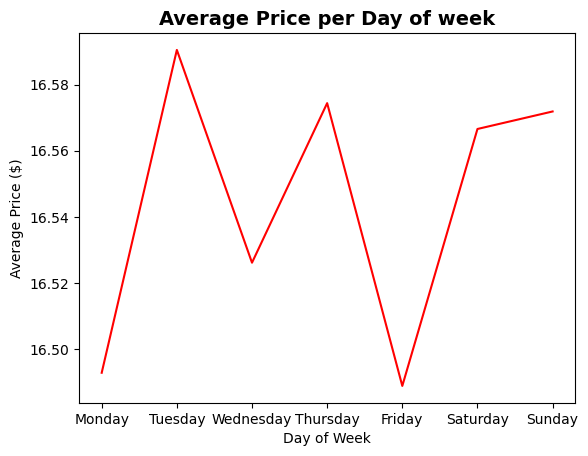

In [11]:
daily_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_change = df[['price','day_name']].copy()
daily_change['day_name'] = pd.Categorical(daily_change['day_name'], categories = daily_order, ordered=True)
daily_change = daily_change.groupby('day_name' , observed=False).mean()
daily_change = daily_change.reindex(daily_order)

sns.lineplot(x = 'day_name', y = 'price', data = daily_change, color = 'red')
plt.title('Average Price per Day of week', fontsize = 14, weight = 'bold')
plt.ylabel('Average Price ($)')
plt.xlabel('Day of Week')
plt.show();

**Finding:** Prices are generally higher on weekdays, likely due to commuter demand. Interestingly, Friday shows a dip, possibly because the evening commute is less concentrated and driver supply increases in anticipation of the weekend.

### Which specific ride service is the most expensive?
I will create a sorted bar plot to compare the average prices of all available Uber and Lyft services.

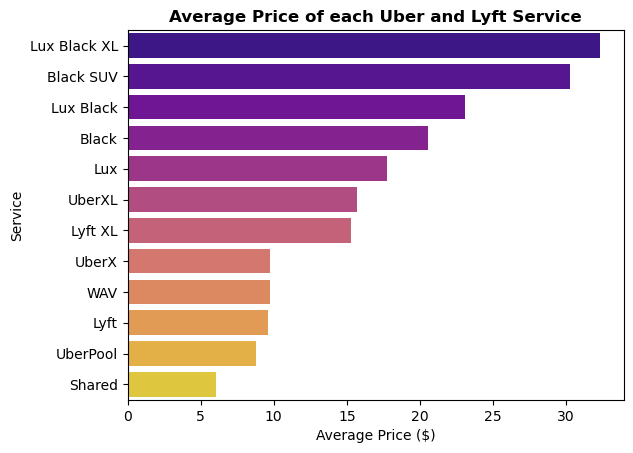

In [120]:
service_price = df[['name','price']]
service_price = service_price.groupby('name').mean().sort_values(by = 'price', ascending = False).reset_index()

sns.barplot(data = service_price, x = 'price', y = 'name', hue = 'name', palette = 'plasma')
plt.xlabel('Average Price ($)')
plt.ylabel('Service')
plt.title('Average Price of each Uber and Lyft Service', weight = 'bold')
plt.show();

**Finding:** As expected, premium services like 'Lux Black XL' are the most expensive, while shared ride options are the cheapest.

### Average Price of Uber vs Lyft
I'll create a bar plot in order to compare the average price of Uber to Lyft.

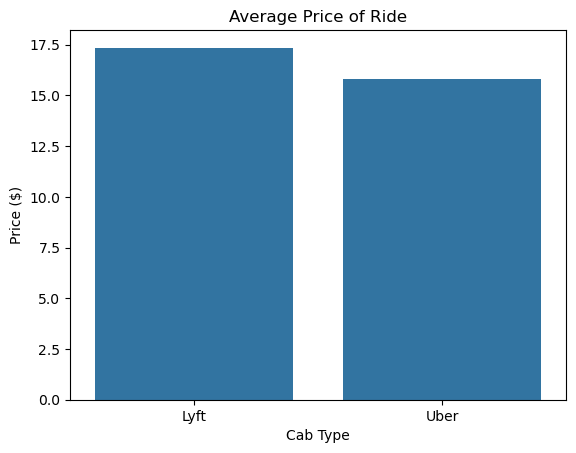

In [117]:
price_diff = df[['cab_type','price']]
price_diff = price_diff.groupby('cab_type').mean().reset_index()
sns.barplot(data = price_diff, x = 'cab_type', y = 'price')
plt.title('Average Price of Ride')
plt.xlabel('Cab Type')
plt.ylabel('Price ($)')
plt.show();

In [14]:
df[df['cab_type'] == 'Lyft'].shape[0]

307408

In [15]:
df[df['cab_type'] == 'Uber'].shape[0]

330568

**Finding:** The graph suggests that Uber is slightly cheaper than Lyft. However, there are more data entries for Uber compared to Lyft, which could be a factor in Lyft's slightly increased price.

### What is the relationship between distance and price?
A scatter plot with a regression line is the perfect way to visualize this core relationship.

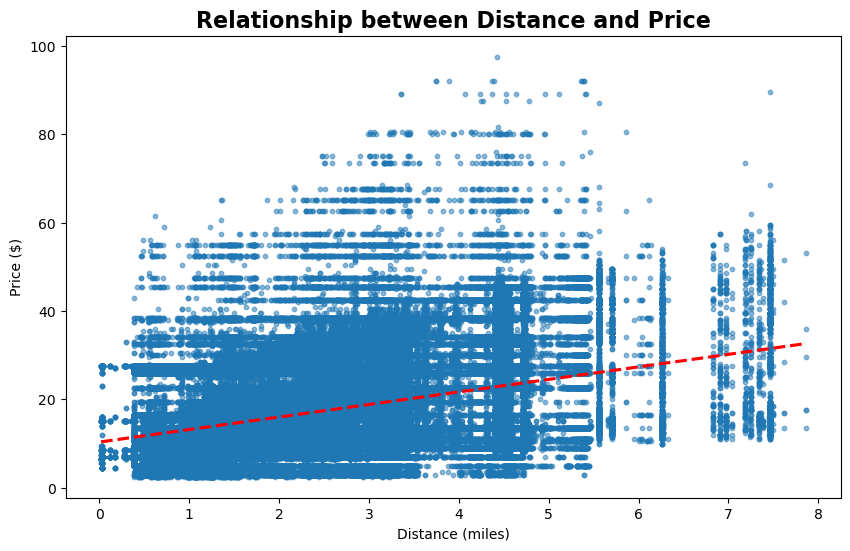

In [16]:
plt.figure(figsize = (10, 6))
sns.regplot(data = df, x = 'distance', y = 'price', line_kws={'color': 'red', 'linestyle': '--'}, scatter_kws={'alpha': 0.5, 's': 10} )

plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.title('Relationship between Distance and Price', fontsize = 16, weight = 'bold')
plt.show();

**Finding:** There is a strong, positive linear relationship between distance and price. As the trip distance increases, the price increases predictably.

### How do the numerical features correlate with price?
A correlation heatmap provides a quick overview of the linear relationships between all numerical variables.

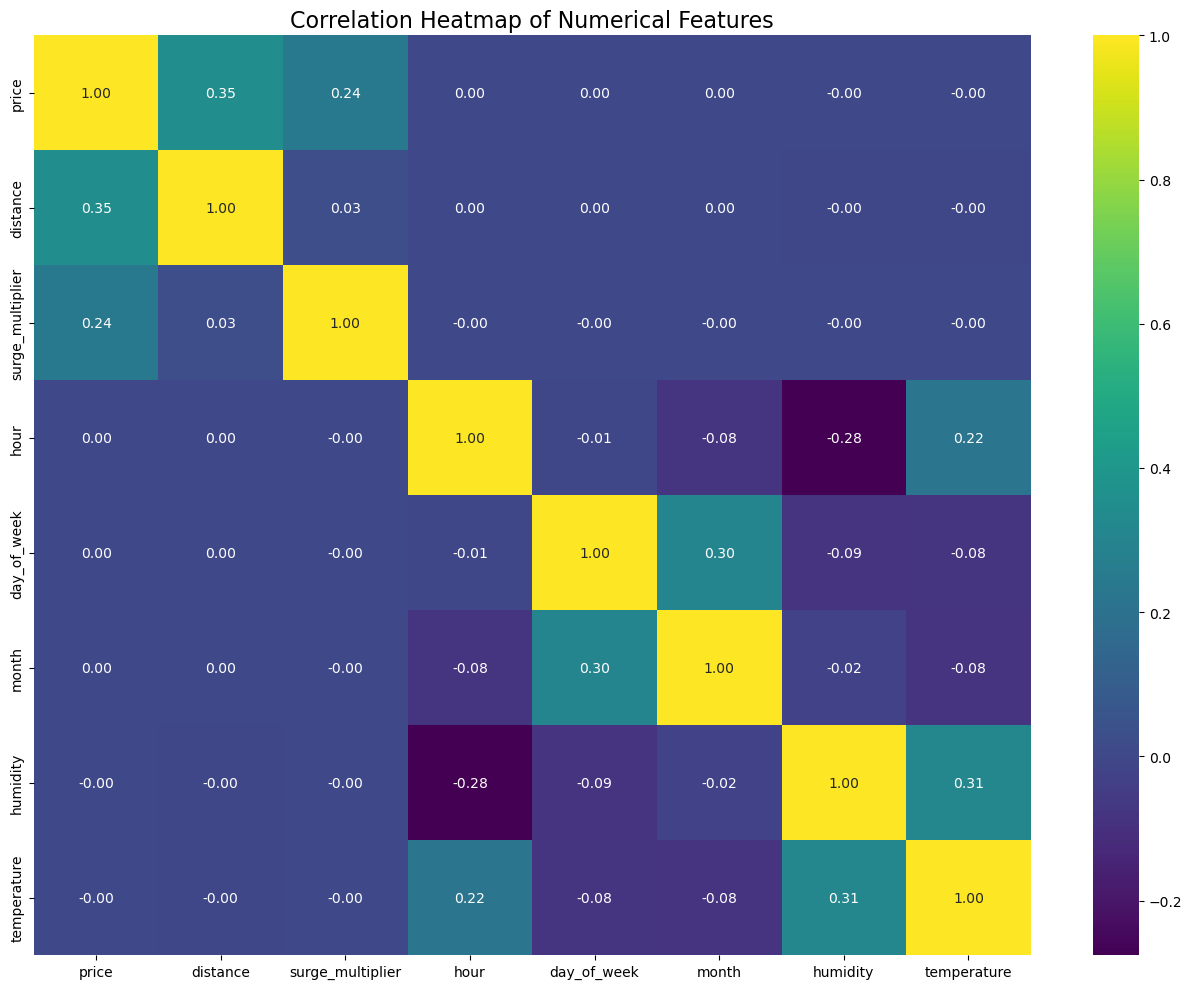

In [121]:
numerical_cols = ['price', 'distance', 'surge_multiplier','hour', 'day_of_week', 'month', 'humidity', 'temperature']

correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = "viridis")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show();

**Finding:** The heatmap confirms that `distance` has the strongest positive correlation with `price`. This is followed by `surge_multiplier`, which makes perfect sense since the surge multiplier is explicitly designed to increase the fare during periods of high demand. Interestingly, other features, such as `temperature` and `hour`, showed little correlation; their impact is likely indirect, as they are often the root causes of a surge multiplier being applied.

# 3. Data Preprocessing 🤖
---
Before training the model, the data needs to be in a purely numerical format. I will use `OneHotEncoder` to convert categorical features into binary columns and then split the data into training and testing sets.

In [103]:
# Create instance of Encoder
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

# Handle non-numerical data
features = df[['distance', 'hour', 'day_of_week', 'cab_type', 'name', 'temperature', 'month','humidity', 'cloudCover', 'short_summary','surge_multiplier']]
encoded_values = encoder.fit_transform(features[['cab_type', 'name', 'short_summary']])
newCols = encoder.get_feature_names_out(['cab_type', 'name', 'short_summary'])

# Create a fully numerical data set
df_encoded = pd.DataFrame(encoded_values, columns = newCols, index = features.index)
final_df = pd.concat([features.drop(columns = ['cab_type', 'name', 'short_summary']), df_encoded],axis = 1)

final_df.head()

,distance,hour,day_of_week,temperature,month,humidity,cloudCover,surge_multiplier,cab_type_Lyft,cab_type_Uber,...,name_WAV,short_summary_ Clear,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain
0,0.44,9,6,42.34,12,0.68,0.72,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.44,2,1,43.58,11,0.94,1.00,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.44,1,2,38.33,11,0.75,0.03,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.44,4,4,34.38,11,0.73,0.00,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.44,3,3,37.44,11,0.70,0.44,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Train-Test Split and Feature Scaling
I'll now split the prepared data into an 80% training set and a 20% testing set. This ensures an unbiased evaluation of the model's performance. I will also scale the numerical features using `StandardScaler` so that all variables have a similar scale.

In [106]:
# Define X and y from the final DataFrame
X = final_df
y = df['price']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Scale the Data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Note:** To prevent data leakage, fit the scaler on the training data only before using it to transform the test data.

# 4. Model Training & Evaluation ✅
---
With the data prepared, I will now train the Linear Regression model and evaluate its performance on the unseen test set.

In [107]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = model.predict(X_test_scaled)

# Evaluate the model's performance"
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): $1.78
R-squared (R²): 0.93


**Evaluation Results:**

* **Mean Absolute Error (MAE): ~1.78** -  This means, on average, the model's price prediction was off by about $1.78.
* **R-squared (R²): 0.93** - The model was able to explain 93% of the variance in the ride prices, indicating a very strong fit.

### How did the model perform visually?

Below is a scatterplot that visually displays the model's results compared to the perfect prediction of ride price.

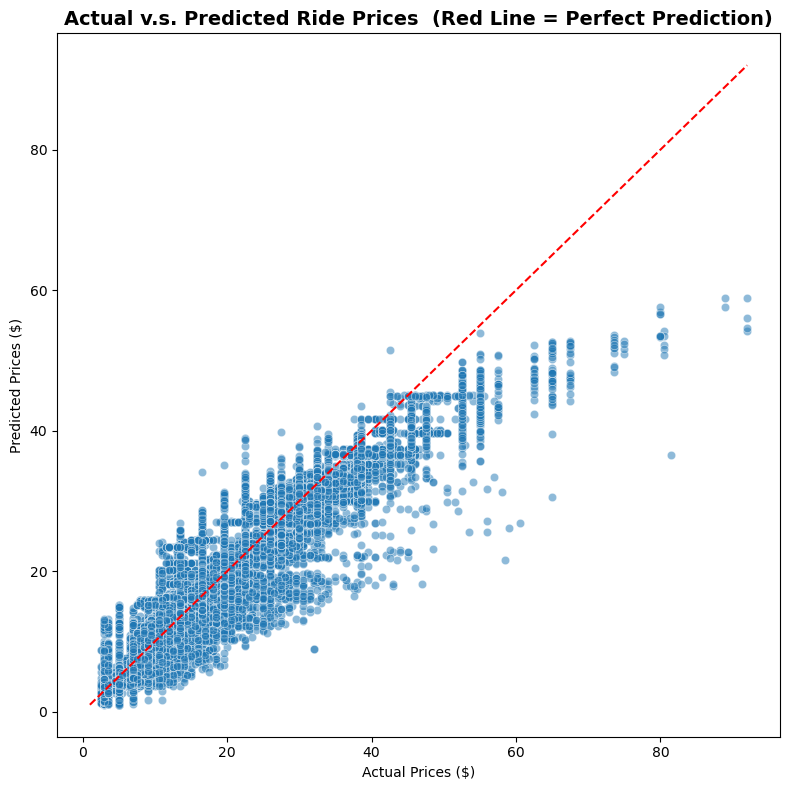

In [108]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x = y_test, y = predictions, alpha=0.5)

line_start = min(y_test.min(), predictions.min())
line_end = max(y_test.max(), predictions.max())

plt.plot([line_start, line_end], [line_start, line_end], 'r--')

plt.xlabel("Actual Prices ($)")
plt.ylabel("Predicted Prices ($)")
plt.title("Actual v.s. Predicted Ride Prices  (Red Line = Perfect Prediction)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show();

**Finding:**  After graphing out the model's prediction, I can see that the model struggles with accurate predictions when it comes to expensive rides. However, the graph is accurate with cheaper rides. This could be due to the data imbalance when it comes to more expensive entries. Since there are more cheap rides in the dataset to train on, the model's accuracy favors cheaper rides.

### Which Feature had the most impact on the Price?

Below, I created a barplot to display the impact of each feature to visually examine which features made the price more expensive and which made it cheaper.

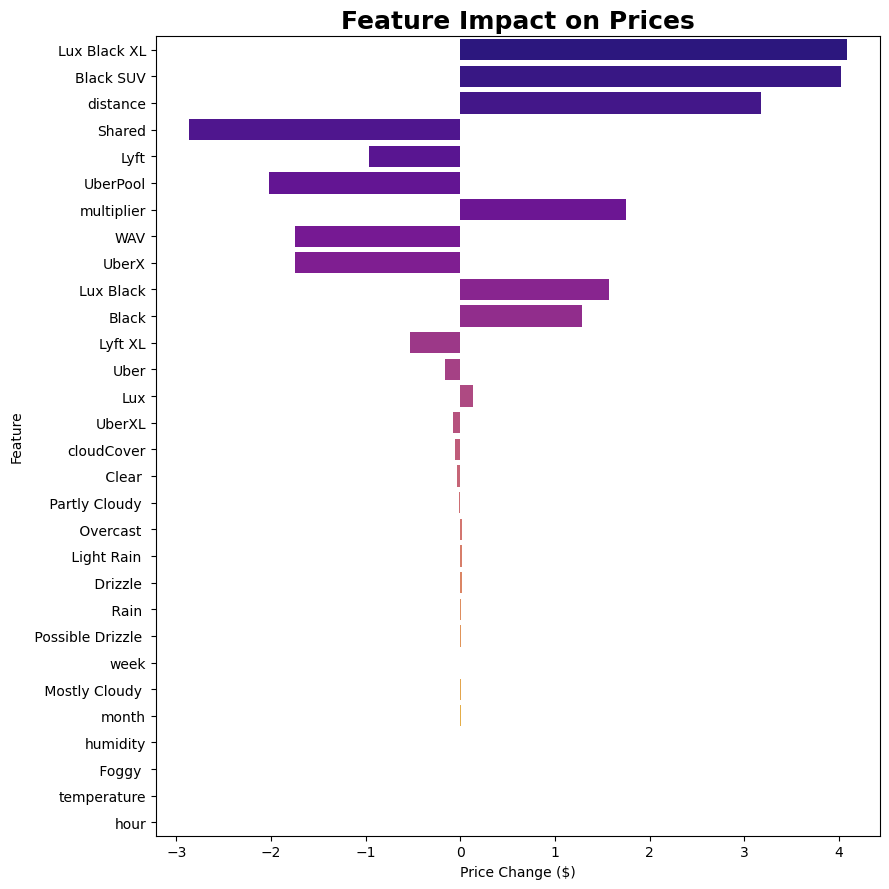

In [119]:
coefficients = model.coef_
feature_names = X_train.columns

# sort values by absolute value to measure impact regardless of direction
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficients': coefficients})
feature_importance['abs_coeff'] = feature_importance.get('Coefficients').abs()
feature_importance.sort_values(by = 'abs_coeff', ascending = False, inplace = True)

# Rename Features for clarity
feature_importance['Feature'] = feature_importance.get('Feature').str.split('_').apply(lambda x: x[-1] if len(x) > 1 else x[0])


plt.figure(figsize = (9,9))

sns.barplot(data = feature_importance, x = 'Coefficients', y = 'Feature', hue = 'Feature', palette = "plasma", errorbar = None)

plt.title("Feature Impact on Prices", fontsize = 18, weight = 'bold')
plt.ylabel('Feature')
plt.xlabel('Price Change ($)')
plt.tight_layout()
plt.show();

**Finding:** It becomes clear that the features that make the price significantly more expensive are the `Lux Black XL` option, `Black SUV` option, and `distance`. This makes sense as `distance` was a significant correlation in our heat map, and the other two are among the more expensive options you can select. On the other hand, `Shared` and `UberPool` make the ride significantly cheaper as you are sharing the service amongst others in order to save money.

What's interesting is that the weather and the hour of day don't have as much of an impact on price as I thought they would have. This is likely because the surge multiplier (shown as `multiplier` on this graph) directly captures the effects of high demand caused by weather or rush hour, making it a much more powerful predictor than those individual factors.

# Conclusion 📝 
---

Through this project, we explored Uber and Lyft ride data to understand the factors that influence ride prices and built a regression model to predict fares.

**Key Findings from EDA 🔎** 

- The analysis shows that `distance` and `surge_multiplier` are the two features with the strongest positive correlation to price. This indicates that the fare is most directly influenced by how far the trip is and the level of real-time demand.

- Time of day plays a role, with higher average prices during rush hours and late nights.

- The day of the week shows smaller effects, but weekday rides are slightly more expensive on average; likely due to commuter demand and business travel.

- Company differences: The analysis shows that Lyft has a slightly higher average price compared to Uber for similar trips in Boston. It's important to note that the dataset contains more entries for Uber, which could influence the average.

**Model Performance 📊**

- Our regression model achieved an MAE of ~$1.78, meaning predictions are off by about that much on average.

- The model explained approximately 93% of the variance in prices (R²), indicating that it captures the major pricing drivers but not all the complexity.
  
- The model predicts the cheaper rides more accurately than the expensive ones, likely due to having fewer examples of high-fare trips in the training data.

- The model's coefficients reveal that `distance`, service type (e.g., the difference between `Lux Black XL` and `Shared`), and the `surge_multiplier` are the most powerful drivers of price. This confirms that the final fare is a combination of the trip's base length, the chosen service level, and real-time demand.

- Interestingly, individual features like `hour` and the weather conditions had a smaller impact on the model's predictions than expected. This is likely because the `surge_multiplier` feature already accounts for the high-demand conditions caused by these factors.

**Business Implications 💡**

- Riders can use such a model for better price estimation before booking.

- Companies like Uber and Lyft could use this model to gain deeper insights into the factors that drive pricing.

**Limitations & Next Steps ⚠️**

- The model incorporates external factors like traffic and events indirectly through the `surge_multiplier`, but lacks direct features (e.g., real-time traffic data, event schedules) that could provide more granular predictive power.

- Future work could explore non-linear models (e.g., Random Forests, Gradient Boosting) for potentially higher accuracy.

- Building a dashboard or prediction tool could make this analysis more interactive and useful for end users.